<a href="https://colab.research.google.com/github/matiqiu/mcd-scanveg-ai-model-experiments/blob/main/Exp05_ResNet50_Finetune_10layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Importaciones y configuración inicial
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import os
import shutil
import pandas as pd
from google.colab import files

In [ ]:
# 2. Autenticación de Kaggle
files.upload()  # Subir el token de Kaggle

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Descarga del Dataset
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 654M/658M [00:10<00:00, 37.1MB/s]
100% 658M/658M [00:10<00:00, 63.3MB/s]


In [ ]:
# 3. Descarga del Dataset
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)
replace PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# 4. Preparación del Dataset
src_dir = '/content/PlantVillage'
dst_dir = '/content/tomate_10clases'
tomato_classes = [
    'Tomato_Bacterial_spot',
    'Tomato_Early_blight',
    'Tomato_Late_blight',
    'Tomato_Leaf_Mold',
    'Tomato_Septoria_leaf_spot',
    'Tomato_Spider_mites_Two_spotted_spider_mite',
    'Tomato__Target_Spot',
    'Tomato__Tomato_YellowLeaf__Curl_Virus',
    'Tomato__Tomato_mosaic_virus',
    'Tomato_healthy'
]

os.makedirs(dst_dir, exist_ok=True)
for cls in tomato_classes:
    src_cls_path = os.path.join(src_dir, cls)
    dst_cls_path = os.path.join(dst_dir, cls)
    if os.path.isdir(src_cls_path):
        if os.path.exists(dst_cls_path):
            shutil.rmtree(dst_cls_path)
        shutil.copytree(src_cls_path, dst_cls_path)
    else:
        print(f"⚠️  Clase no encontrada: {cls}")

print("Carpetas copiadas:")
print(sorted(os.listdir(dst_dir)))

Carpetas copiadas:
['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
# 5. Generadores de Datos
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 14  # Total de épocas para el experimento

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dst_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training'
)

val_gen = datagen.flow_from_directory(
    dst_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)

Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.


In [ ]:
# 6. Construcción del Modelo
base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)

# Primera Fase: Congelar todas las capas del modelo base
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),  # Tasa de aprendizaje más alta
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import time

# 1. Calcular los pasos por época
steps_per_epoch = train_gen.n // train_gen.batch_size

# 2. Tomar un solo lote de datos
x_sample, y_sample = next(train_gen)

# 3. Medir el tiempo de un solo paso de entrenamiento
start_time = time.time()
model.train_on_batch(x_sample, y_sample)
end_time = time.time()

# 4. Calcular y mostrar la estimación
time_per_step = end_time - start_time
estimated_time_per_epoch_seconds = time_per_step * steps_per_epoch
estimated_time_per_epoch_minutes = estimated_time_per_epoch_seconds / 60
total_time_phase1_minutes = estimated_time_per_epoch_minutes * (EPOCHS // 2)

print(f"⏱️ Tiempo por paso: {time_per_step:.4f} segundos")
print(f"⏳ Pasos por época: {steps_per_epoch}")
print(f"🕒 Tiempo estimado por época: {estimated_time_per_epoch_minutes:.2f} minutos")
print(f"⏰ Tiempo total estimado para la Fase 1 ({EPOCHS // 2} épocas): {total_time_phase1_minutes:.2f} minutos")

⏱️ Tiempo por paso: 11.3030 segundos
⏳ Pasos por época: 400
🕒 Tiempo estimado por época: 75.35 minutos
⏰ Tiempo total estimado para la Fase 1 (7 épocas): 527.47 minutos


### **Celda 4: Fase 1 de Entrenamiento (Capas Congeladas)**
Entrenamos solo el clasificador. Asegúrate de tener tu Google Drive montado para guardar los resultados.

In [ ]:
# 7. Callbacks y Entrenamiento (Primera Fase)
EXPERIMENT_NAME = "exp05_resnet50_finetune_10layers"
model_path_phase1 = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_phase1.keras'
history_path_phase1 = f'/content/drive/MyDrive/PROYECTO/{EXPERIMENT_NAME}_phase1_history.pkl'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(model_path_phase1, save_best_only=True)
]

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS // 2,  # Primera mitad de las épocas
    callbacks=callbacks
)

# Guardar el progreso después de la primera fase
model.save(model_path_phase1)
with open(history_path_phase1, 'wb') as f:
    pickle.dump(history1.history, f)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2594s 6s/step - accuracy: 0.5345 - loss: 1.3971 - val_accuracy: 0.7952 - val_loss: 0.6223
Epoch 2/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2564s 6s/step - accuracy: 0.7882 - loss: 0.6456 - val_accuracy: 0.8327 - val_loss: 0.5013
Epoch 3/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2744s 7s/step - accuracy: 0.8121 - loss: 0.5615 - val_accuracy: 0.8490 - val_loss: 0.4605
Epoch 4/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2579s 6s/step - accuracy: 0.8260 - loss: 0.5108 - val_accuracy: 0.8612 - val_loss: 0.4327
Epoch 5/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2746s 7s/step - accuracy: 0.8291 - loss: 0.4972 - val_accuracy: 0.8712 - val_loss: 0.3836
Epoch 6/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2651s 6s/step - accuracy: 0.8488 - loss: 0.4600 - val_accuracy: 0.8699 - val_loss: 0.3896
Epoch 7/7
401/401 ━━━━━━━━━━━━━━━━━━━━ 2576s 6s/step - accuracy: 0.8410 - loss: 0.4677 - val_accuracy: 0.8759 - val_loss: 0.3750


In [ ]:
# 8. Segunda Fase: Descongelar las últimas 10 capas del modelo base
print("Capas entrenables antes de descongelar:", len(model.trainable_variables))
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False
print("Capas entrenables después de descongelar:", len(model.trainable_variables))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Tasa de aprendizaje más baja
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Capas entrenables antes de descongelar: 2
Capas entrenables después de descongelar: 11


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 9. Callbacks y Entrenamiento (Segunda Fase)
PROJECT_DIR = "/content/drive/MyDrive/PROYECTO"
EXPERIMENT_NAME = "exp05_resnet50_finetune_10layers"
output_dir = os.path.join(PROJECT_DIR, EXPERIMENT_NAME)
os.makedirs(output_dir, exist_ok=True)

# 4. Generadores de Datos
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 10
EPOCHS = 14  # Total de épocas para el experimento
dst_dir = '/content/tomate_10clases'

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    dst_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training'
)

val_gen = datagen.flow_from_directory(
    dst_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False
)


model_path_phase1 = os.path.join(output_dir, f'{EXPERIMENT_NAME}_phase1.keras')
history_path_phase1 = os.path.join(output_dir, f'{EXPERIMENT_NAME}_phase1_history.pkl')
model_path_phase2 = os.path.join(output_dir, f'{EXPERIMENT_NAME}_phase2.keras')
history_path_phase2 = os.path.join(output_dir, f'{EXPERIMENT_NAME}_phase2_history.pkl')

# Cargar el modelo de la primera fase
if os.path.exists(model_path_phase1):
    model = tf.keras.models.load_model(model_path_phase1)
else:
    print(f"El archivo del modelo no se encontró en la ruta: {model_path_phase1}")


# Cargar el historial de la primera fase
if os.path.exists(history_path_phase1):
    with open(history_path_phase1, 'rb') as f:
        history1_data = pickle.load(f)
else:
    history1_data = {}


callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint(model_path_phase2, save_best_only=True)
]

# Asegurarse que la época inicial es la correcta
initial_epoch = 7

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,  # Usar el número total de épocas
    initial_epoch=initial_epoch,  # Comenzar desde la epoca 7
    callbacks=callbacks
)

# Guardar el progreso final después de la segunda fase
model.save(model_path_phase2)
with open(history_path_phase2, 'wb') as f:
    pickle.dump(history2.history, f)

Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.
El archivo del modelo no se encontró en la ruta: /content/drive/MyDrive/PROYECTO/exp05_resnet50_finetune_10layers/exp05_resnet50_finetune_10layers_phase1.keras


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 8/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 2971s 7s/step - accuracy: 0.2927 - loss: 2.0419 - val_accuracy: 0.6245 - val_loss: 1.1956
Epoch 9/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 2920s 7s/step - accuracy: 0.6182 - loss: 1.2118 - val_accuracy: 0.7248 - val_loss: 0.8779
Epoch 10/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 2930s 7s/step - accuracy: 0.7092 - loss: 0.9152 - val_accuracy: 0.7708 - val_loss: 0.7201
Epoch 11/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 2923s 7s/step - accuracy: 0.7505 - loss: 0.7710 - val_accuracy: 0.7999 - val_loss: 0.6238
Epoch 12/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 2916s 7s/step - accuracy: 0.7909 - loss: 0.6668 - val_accuracy: 0.8086 - val_loss: 0.5667
Epoch 13/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 2884s 7s/step - accuracy: 0.8051 - loss: 0.5983 - val_accuracy: 0.8252 - val_loss: 0.5157
Epoch 14/14
401/401 ━━━━━━━━━━━━━━━━━━━━ 2952s 7s/step - accuracy: 0.8187 - loss: 0.5511 - val_accuracy: 0.8415 - val_loss: 0.4865


### **Celda 6: Evaluación y Visualización de Resultados**
Finalmente, evaluamos el rendimiento del modelo ajustado y visualizamos las curvas de aprendizaje y la matriz de confusión.

                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.85      0.93      0.89       425
                        Tomato_Early_blight       0.72      0.61      0.66       200
                         Tomato_Late_blight       0.82      0.86      0.84       381
                           Tomato_Leaf_Mold       0.81      0.76      0.79       190
                  Tomato_Septoria_leaf_spot       0.80      0.79      0.79       354
Tomato_Spider_mites_Two_spotted_spider_mite       0.81      0.86      0.84       335
                        Tomato__Target_Spot       0.75      0.71      0.73       280
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.97      0.96      0.96       641
                Tomato__Tomato_mosaic_virus       0.79      0.72      0.75        74
                             Tomato_healthy       0.89      0.89      0.89       318

                                   accuracy                    

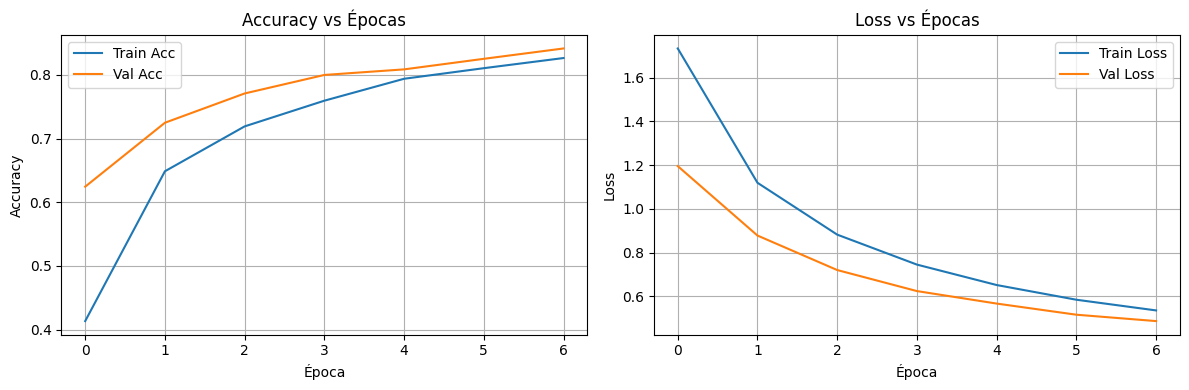

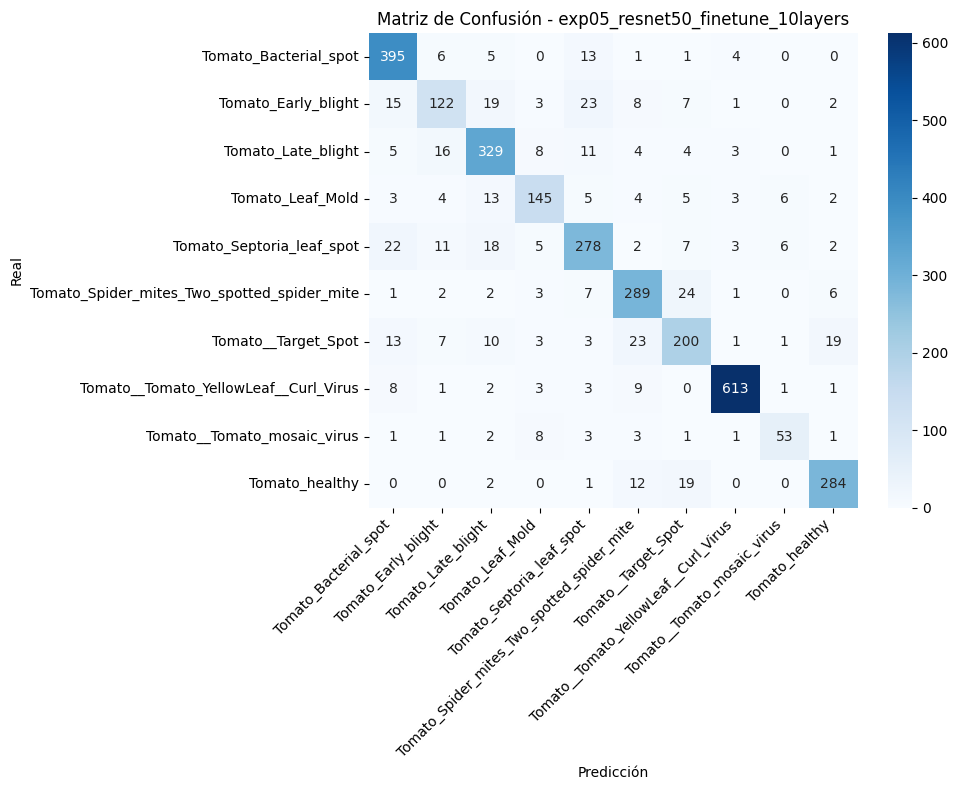

In [ ]:
# 9. Evaluación y Visualización
val_gen.reset()
y_pred_prob = model.predict(val_gen, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))

# 10. Gráficos de métricas
hist_df1 = pd.DataFrame(history1_data) # Usar history1_data en lugar de history1
hist_df2 = pd.DataFrame(history2.history) # Usar history2.history
hist_df = pd.concat([hist_df1, hist_df2], ignore_index=True)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_df['accuracy'], label='Train Acc')
plt.plot(hist_df['val_accuracy'], label='Val Acc')
plt.title('Accuracy vs Épocas'); plt.xlabel('Época'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Val Loss')
plt.title('Loss vs Épocas'); plt.xlabel('Época'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'{EXPERIMENT_NAME}_curvas.png'), dpi=300)
plt.show()

# 11. Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys())
plt.title(f'Matriz de Confusión - {EXPERIMENT_NAME}')
plt.xlabel('Predicción'); plt.ylabel('Real')
plt.xticks(rotation=45, ha='right'); plt.tight_layout()
plt.savefig(os.path.join(output_dir, f'{EXPERIMENT_NAME}_matrix.png'), dpi=300)
plt.show()